<a href="https://colab.research.google.com/github/kisozipaul/rasterio-on-geotiff/blob/main/using_xarrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade stackstac
!pip install planetary-computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.3 MB/s eta 0:00:00


In [3]:
 !pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00


In [4]:
from pystac_client import Client
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import io
import pandas as pd
import stackstac
import rasterio
from typing import Callable, Dict, List, Optional, Union
import planetary_computer as pc

In [5]:
stac_url_panetary_computer = 'https://planetarycomputer.microsoft.com/api/stac/v1'

In [6]:
# itemediate function to handle data format
def handle_feature_collection(feature_collection):
  type_location_geojson = feature_collection["type"]
  if type_location_geojson not in ["Point", "Polygon", "feature", "FeatureCollection"]:

              raise ValueError("Only Point and Polygon types are supported.")

  if type_location_geojson == "FeatureCollection":
          return feature_collection["features"][0]["geometry"]

In [7]:
def get_stack_items(stac_url:str,
                    collection:str,
                    datetime:str,
                    feature_collection: str,
                    cloud_cover:int = 10,
                    planet_comp:bool = True
                    ):

  client = Client.open(stac_url)
  feature_collection = handle_feature_collection(feature_collection)
  search = client.search(
    collections=[collection],
    intersects=feature_collection,
    datetime=datetime,
    query=[f"eo:cloud_cover<{cloud_cover}"],
    limit=10
    )
  if planet_comp:
    items = pc.sign(search)
  else:
    items = search.item_collection()

  print(f"Found {len(items)} items")

  return items



In [8]:
# Define a GeoJSON feature collection for the search
feature_collection = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              35.091792388971584,
              0.5900286891046989
            ],
            [
              35.091792388971584,
              0.5741557135470998
            ],
            [
              35.123369292604906,
              0.5741557135470998
            ],
            [
              35.123369292604906,
              0.5900286891046989
            ],
            [
              35.091792388971584,
              0.5900286891046989
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

gdf = gpd.GeoDataFrame.from_features(feature_collection["features"])
bbox = gdf.total_bounds

In [9]:
sentinel2_items = get_stack_items(stac_url_panetary_computer,'sentinel-2-l2a',
                                  "2021-01-01/2021-06-30", feature_collection,
                                  )

Found 14 items


In [10]:
len(sentinel2_items)

14

In [11]:
bbox = tuple(bbox)

In [12]:
# Create an xarray.DataArray from the items, reproject and stack by time.
resolution_degrees = 0.0000899
s2_stack = stackstac.stack(sentinel2_items, epsg=4326 ,bounds_latlon=bbox, resolution=resolution_degrees)
s2_stack

<xarray.DataArray 'stackstac-50570a9cf5e5f1f29e683b8d9ac18943' (time: 14,
                                                                band: 17,
                                                                y: 178, x: 352)> Size: 119MB
dask.array<fetch_raster_window, shape=(14, 17, 178, 352), dtype=float64, chunksize=(1, 1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * band                                     (band) <U7 476B 'AOT' ... 'preview'
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    ...                                       ...
    proj:bbox                                (band) object 136B [699960.0, -9...
    proj:shape                               (band) object 136B [10980, 10980...
    common_name                              (band) object 136B None ... None
    center_wavelength                        (band) object 136B None ... None
    full_width_half_max                      (band) object 136B None ... None
    epsg                                     int64 8B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(35.0917458, 0.5741014, 35.1233...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 35.09|\n| 0.00,-0.00, 0.59|\n| 0.00, 0.00, 1.00|
    resolution:  8.99e-05

In [13]:
# Band names are not trivial from the initial query
s2_stack.band

<xarray.DataArray 'band' (band: 17)> Size: 476B
array(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview'], dtype='<U7')
Coordinates: (12/20)
  * band                                     (band) <U7 476B 'AOT' ... 'preview'
    sat:orbit_state                          <U10 40B 'descending'
    s2:mgrs_tile                             <U5 20B '36NYF'
    instruments                              <U3 12B 'msi'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    proj:code                                <U10 40B 'EPSG:32636'
    ...                                       ...
    proj:bbox                                (band) object 136B [699960.0, -9...
    proj:shape                               (band) object 136B [10980, 10980...
    common_name                              (band) object 136B None ... None
    center_wavelength                        (band) object 136B None ... None
    full_width_half_max                      (band) object 136B None ... None
    epsg                                     int64 8B 4326

In [14]:
# Create mask values
mask_values = [ 3,8,9, 10]  # Cloud shadows , Cloud medium probability, Thin cirrus

In [15]:
def value_mask(data_mask: xr.DataArray, mask_values: Union[int, List[int]]) -> xr.DataArray:
    """
    Mask data array using the provided mask values.
    :param data_mask xr.DataArray: Data array containing values to mask e.g., Sentinel-2 SCL band.
    :param mask_values int or list: Value(s) in the data array to mask e.g., [3, 8, 9, 10] for clouds.
    :return xr.DataArray: Boolean data array of masked values.
    :raises ValueError: If no mask values are provided.
    """
    if not mask_values:
        raise ValueError("No mask values provided.")
    mask_values = [mask_values] if isinstance(mask_values, int) else mask_values
    return data_mask.isin(mask_values)

In [16]:
cloud_mask = value_mask(s2_stack.sel(band="SCL"), mask_values)

In [17]:
s2_stack_cloud_masked = s2_stack.where(~cloud_mask)
# scale the images
s2_stack_cloud_masked = s2_stack_cloud_masked / 10000
s2_stack_cloud_masked = s2_stack_cloud_masked.groupby("band").first()

In [18]:
s2_stack_cloud_masked

<xarray.DataArray 'stackstac-50570a9cf5e5f1f29e683b8d9ac18943' (time: 14,
                                                                band: 17,
                                                                y: 178, x: 352)> Size: 119MB
dask.array<transpose, shape=(14, 17, 178, 352), dtype=float64, chunksize=(1, 1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326
  * band                                     (band) object 136B 'AOT' ... 'vi...

In [19]:
s2_stack_cloud_masked.band

<xarray.DataArray 'band' (band: 17)> Size: 136B
array(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A', 'SCL', 'WVP', 'preview', 'visual'], dtype=object)
Coordinates:
    sat:orbit_state                          <U10 40B 'descending'
    s2:mgrs_tile                             <U5 20B '36NYF'
    instruments                              <U3 12B 'msi'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    proj:code                                <U10 40B 'EPSG:32636'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    sat:relative_orbit                       int64 8B 135
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    epsg                                     int64 8B 4326
  * band                                     (band) object 136B 'AOT' ... 'vi...

In [20]:
s2_filtered_stack = s2_stack_cloud_masked.sel(band=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09','B11', 'B12', 'B8A',])

s2_xarray_ds = s2_filtered_stack.to_dataset(dim="band")
s2_xarray_ds

<xarray.Dataset> Size: 84MB
Dimensions:                                  (time: 14, y: 178, x: 352)
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326
Data variables:
    B01                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B02                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B03                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B04                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B05                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B06                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B07                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B08                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B09                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B11                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B12                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B8A                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>

In [21]:
# rename the bands
current_names = ['B03','B02', 'B04', 'B08', 'B11', 'B12', 'B05',
                             'B01', 'B06', 'B07', 'B8A',
                            'B09',
                             ]
common_names = ['green', 'blue', 'red', 'nir', 'swir1', 'swir2', 'red_edge',
                              'aerosols', 'red_edge_2', 'red_edge_3', 'red_edge_4',
                            'water_vapour',
                            ]
def rename_bands(dataset,bands:list, desired_names:list):
    name_dict = dict(
    )
    for current_name, desired_name in zip(bands, desired_names):
        name_dict[current_name] = desired_name
    # print(name_dict)

    return dataset.rename(name_dict)

In [22]:
s2_xarray_ds = rename_bands(s2_xarray_ds, current_names, common_names)
s2_xarray_ds

<xarray.Dataset> Size: 84MB
Dimensions:                                  (time: 14, y: 178, x: 352)
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326
Data variables:
    aerosols                                 (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    blue                                     (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    green                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge                                 (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_2                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_3                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    nir                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    water_vapour                             (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    swir1                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    swir2                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_4                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>

In [23]:
# we can still filter the xarray ds bands
blue = s2_xarray_ds['blue']
blue

<xarray.DataArray 'blue' (time: 14, y: 178, x: 352)> Size: 7MB
dask.array<getitem, shape=(14, 178, 352), dtype=float64, chunksize=(1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326

In [24]:
# for more than one band
red_green = s2_xarray_ds[['blue', 'green']]
red_green

<xarray.Dataset> Size: 14MB
Dimensions:                                  (time: 14, y: 178, x: 352)
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326
Data variables:
    blue                                     (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    green                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>

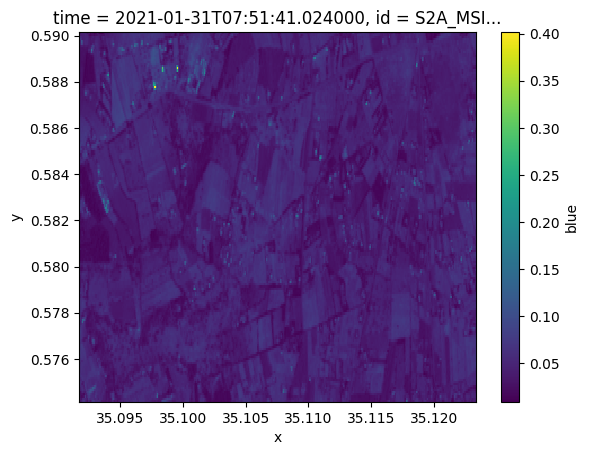

In [25]:
s2_xarray_ds.isel(time=2).blue.plot(cmap='viridis')

In [26]:
x, y = 35.091792388971584, 0.5900286891046989

In [27]:
# lets calculate an index for example ndvi
ndvi = (s2_xarray_ds.nir - s2_xarray_ds.red) / (s2_xarray_ds.nir + s2_xarray_ds.red)

In [28]:
"""Canopy chrophophyl content index (CCCI): Measures nitrogen deficiency in crops including maize"""

ccci = ((s2_xarray_ds.red_edge - s2_xarray_ds.red)/(s2_xarray_ds.red_edge + s2_xarray_ds.red)) *((s2_xarray_ds.nir + s2_xarray_ds.red)/2).rename('ccci')


In [29]:
"""Leaf Area Index (LAI)"""
"""
based on https://www.mdpi.com/2072-4292/12/9/1406
𝐋𝐀𝐈=0.310𝑺𝑹−0.098

(1)
where SR is the simple ratio of near-infrared (NIR) and red bands
(Band 8 and Band 4, respectively) calculated using Sentinel-2 Level-2A surface reflectance images.
"""
lai = (0.310 *ndvi - 0.098).rename('lai')

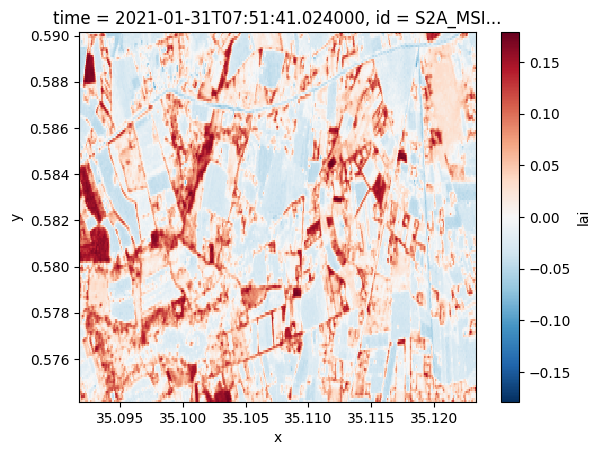

In [30]:
lai.isel(time=2).plot()

In [31]:
""" NDWI"""
ndwi = ((s2_xarray_ds.green-s2_xarray_ds.nir)/(s2_xarray_ds.green+s2_xarray_ds.nir)).rename('ndwi')

In [32]:
time_series_ndvi = ndvi.rename('NDVI').interp(x=x, y=y).compute()

In [33]:
time_series_ndvi

<xarray.DataArray 'NDVI' (time: 14)> Size: 112B
array([0.44360318, 0.28677355, 0.2681644 , 0.25251313, 0.2645755 ,
       0.27995466, 0.2765228 , 0.2951292 ,        nan, 0.42229271,
       0.56195418, 0.58031387,        nan, 0.5222489 ])
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    sat:orbit_state                          <U10 40B 'descending'
    s2:datatake_id                           (time) <U34 2kB 'GS2B_20210106T0...
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    ...                                       ...
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    epsg                                     int64 8B 4326
    x                                        float64 8B 35.09
    y                                        float64 8B 0.59

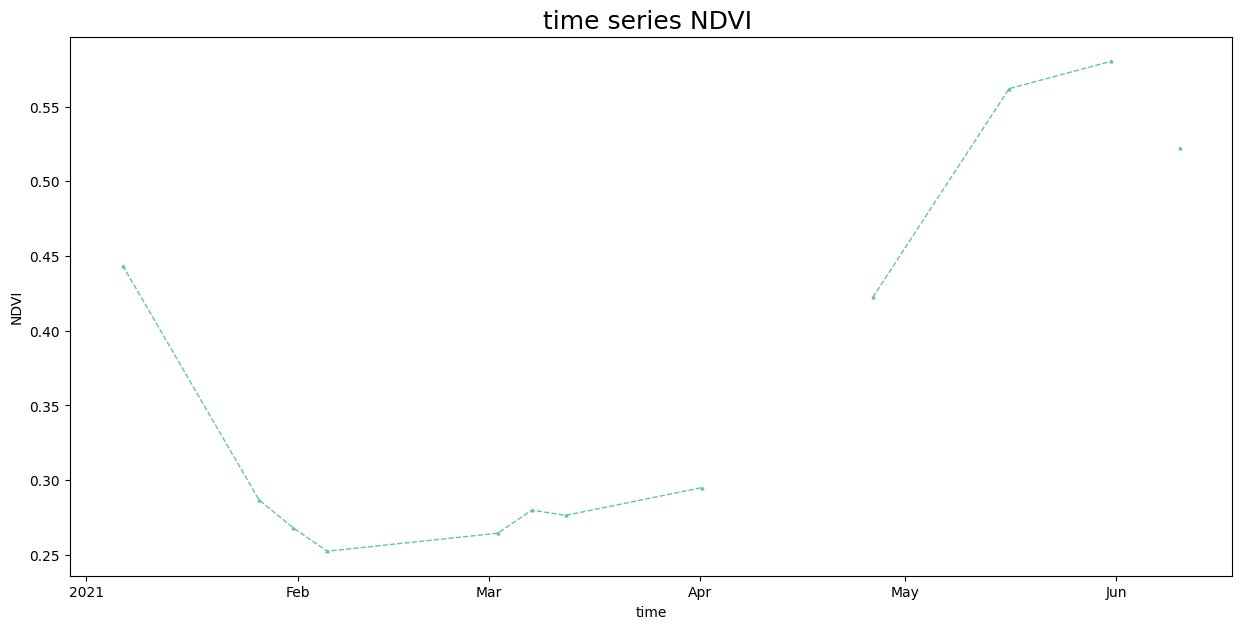

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_ndvi.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)


ax.set_title('time series NDVI ', size = 18)

plt.show()

In [35]:
monthly_ndvi_data = ndvi.resample(time='MS', label='left').mean()

In [36]:
monthly_ndvi_data

<xarray.DataArray (time: 6, y: 178, x: 352)> Size: 3MB
dask.array<stack, shape=(6, 178, 352), dtype=float64, chunksize=(1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    sat:orbit_state                          <U10 40B 'descending'
    s2:mgrs_tile                             <U5 20B '36NYF'
    instruments                              <U3 12B 'msi'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    ...                                       ...
    sat:relative_orbit                       int64 8B 135
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    epsg                                     int64 8B 4326
  * time                                     (time) datetime64[ns] 48B 2021-0...

In [37]:
time_series_monthly_ndvi = monthly_ndvi_data.interp(x=x, y=y).compute()

In [38]:
time_series_monthly_ndvi

<xarray.DataArray (time: 6)> Size: 48B
array([0.33284704, 0.25251313, 0.27368432, 0.35871095, 0.57113402,
       0.5222489 ])
Coordinates: (12/14)
    sat:orbit_state                          <U10 40B 'descending'
    s2:mgrs_tile                             <U5 20B '36NYF'
    instruments                              <U3 12B 'msi'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    proj:code                                <U10 40B 'EPSG:32636'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    ...                                       ...
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    epsg                                     int64 8B 4326
  * time                                     (time) datetime64[ns] 48B 2021-0...
    x                                        float64 8B 35.09
    y                                        float64 8B 0.59

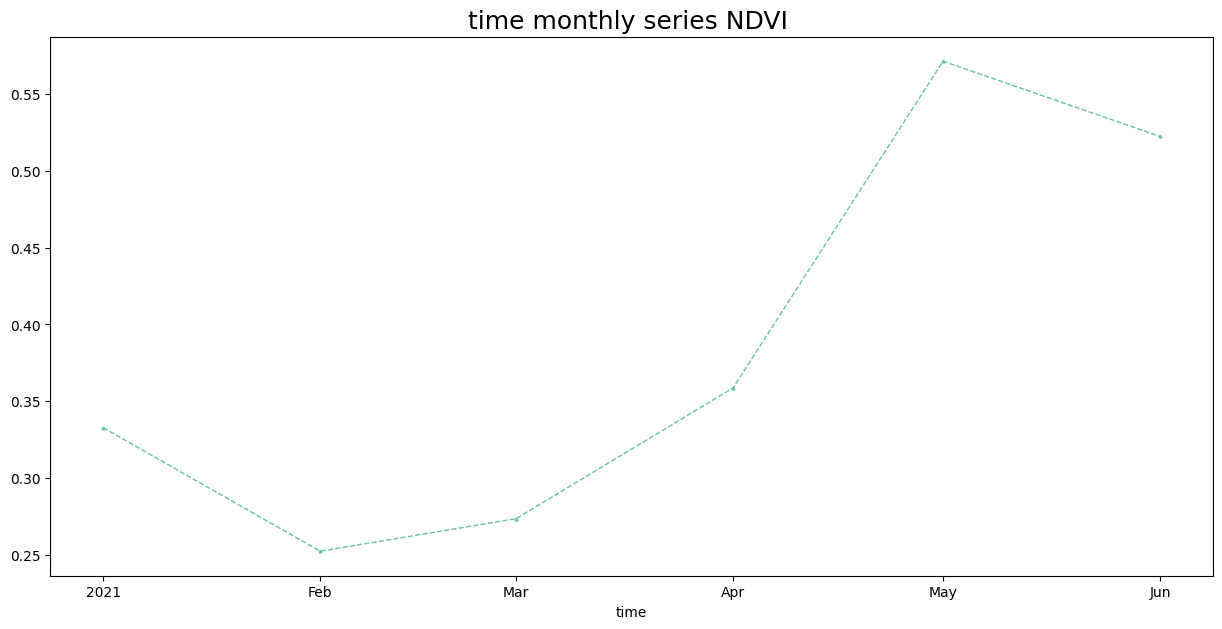

In [39]:
# plot the monthly dataset
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_monthly_ndvi.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
ax.set_title('time monthly series NDVI ', size = 18)

plt.show()

In [42]:
# convert the xarray.Dataset to dask dataframe
s2_dask_df = s2_xarray_ds.to_dask_dataframe()
# you may as well consider to export as images or netcdf files

In [43]:
s2_dask_df.head()

RuntimeError: Assets must have exactly 1 band, but file 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/N/YF/2021/01/06/S2B_MSIL2A_20210106T075219_N0212_R135_T36NYF_20210107T014937.SAFE/GRANULE/L2A_T36NYF_A020038_20210106T080451/QI_DATA/T36NYF_20210106T075219_PVI.tif?st=2025-03-13T14%3A52%3A41Z&se=2025-03-14T15%3A37%3A41Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-03-14T04%3A09%3A58Z&ske=2025-03-21T04%3A09%3A58Z&sks=b&skv=2024-05-04&sig=%2BCPe8gPUabX2qvorx2q5ekEVmHmBIkBRqKwqc3S%2BAH0%3D' has 3. We can't currently handle multi-band rasters (each band has to be a separate STAC asset), so you'll need to exclude this asset from your analysis.

In [44]:
# expor to your desired format
s2_dask_df.to_csv('s2_dask_df.csv') #or parquet


['/content/s2_dask_df.csv/00.part',
 '/content/s2_dask_df.csv/01.part',
 '/content/s2_dask_df.csv/02.part',
 '/content/s2_dask_df.csv/03.part',
 '/content/s2_dask_df.csv/04.part',
 '/content/s2_dask_df.csv/05.part',
 '/content/s2_dask_df.csv/06.part',
 '/content/s2_dask_df.csv/07.part',
 '/content/s2_dask_df.csv/08.part',
 '/content/s2_dask_df.csv/09.part',
 '/content/s2_dask_df.csv/10.part',
 '/content/s2_dask_df.csv/11.part',
 '/content/s2_dask_df.csv/12.part',
 '/content/s2_dask_df.csv/13.part']